In [ ]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 79.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=a47673a7ea6ec8f91c041ffce79077868ec2f372379a59e5077bfe70ce17fbdb
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import japanize_matplotlib
import math

## 関数設定

メモ：よく使うやつ\
self.timebin:時間の刻み幅\
self.diff():レート方程式の時系列データ\
self.error_rate():エラー率を返す\
self.dt_error_rate():エラー率の導関数を返す\
self.production_correct():正しいタンパク質の生産量を返す\
self.calc_EPR():EPRを返す\
self.bar_transport():移動度の棒グラフを返す

--------------------------------------------------
### 定数
$ki$：コドン(Cと表す)とtRNA(c/wと表す)との結合定数\
$m$：tRNAの化学修飾の速度定数\
$v$：リボソーム中にいる化学修飾済みのtRNAからアミノ酸がペプチド鎖に付加される速度定数\
\
変数\
$\frac{k_w^+}{k_w^-}=:KW$：誤tRNAのコドンへの結合の不可逆性,\
$\frac{k_w^-}{k_c^-}=:K_{minus}$：正tRNAに比べて誤tRNAがどれだけコドンから離れやすいか,\
$\frac{m^+}{m^-}=:M$：tRNAの化学修飾の不可逆性,\
$\frac{k_c-}{l_c^+}=\frac{k_w^-}{l_w^+}=:KL$：化学修飾前後でのコドンからの乖離速度定数の比率,\
$\frac{l_c^+}{l_c^-}=:LC$：正tRNAwith修飾のコドンからの乖離の不可逆性,\
$\frac{l_w^+}{l_w^-}=:LW$：誤tRNAwith修飾のコドンからの乖離の不可逆性

尚、初期値はコドンが1、tRNAがcとwで3ずつ、他が0.001ずつとした（完全に0としないのは、エラー率やEPR計算の際のゼロ除算を逃れるため）。



In [ ]:
# パラメータを設定すればEPRとか色々返してくれるようなクラスを作りたい
# 1段階の校正をする回路の設計
class kiprf1():
  def __init__(self,ki,m,v,KW,Kminus,M,KL,LC,LW,init=[1.,3.,3.,0.001,0.001,0.001,0.001,0.001,0.001],timescale=10.0) -> None: # レート方程式の係数の用意（入力からの変換式は上記のmarkdownメモを参照）
    self.kcpl = ki
    self.kcmi = ki/(KW*Kminus)
    self.kwpl = ki
    self.kwmi = ki/KW
    self.mpl = m
    self.mmi = m/M
    self.lcpl = ki/(KW*KL*Kminus)
    self.lcmi = ki/(KW*KL*LC*Kminus)
    self.lwpl = ki/(KW*KL)
    self.lwmi = ki/(KW*KL*LW)
    self.v = v
    #微分方程式用↓
    self.init = init
    self.timelength = timescale #全時間の長さ
    self.timebin = 0.001
    self.timing = int(self.timelength/self.timebin) #全時間の分割数
    self.time = np.linspace(0.0, self.timelength, self.timing) 

  def diff(self): # レート方程式を解いたときに全体がどう動くか追って時系列データを返す
    def kine_dif(x,t): # scipy.odeintに使う関数(微分方程式の右辺)の準備
      C,c,w,Cc,Cw,Cc_,Cw_,Pc,Pw = x
      dC = - self.kcpl*C*c + self.kcmi*Cc - self.kwpl*C*w + self.kwmi*Cw + self.lcpl*Cc_ - self.lcmi*C*c + self.lwpl*Cw_ - self.lwmi*C*w + self.v*Cc_ + self.v*Cw_
      dc = - self.kcpl*C*c + self.kcmi*Cc + self.lcpl*Cc_ - self.lcmi*C*c + self.v*Cc_
      dw = - self.kwpl*C*w + self.kwmi*Cw + self.lwpl*Cw_ - self.lwmi*C*w + self.v*Cw_
      dCc = self.kcpl*C*c - self.kcmi*Cc - self.mpl*Cc + self.mmi*Cc_
      dCw = self.kwpl*C*w - self.kwmi*Cw - self.mpl*Cw + self.mmi*Cw_
      dCc_ = self.mpl*Cc - self.mmi*Cc_ - self.lcpl*Cc_ + self.lcmi*C*c - self.v*Cc_ 
      dCw_ = self.mpl*Cw - self.mmi*Cw_ - self.lwpl*Cw_ + self.lwmi*C*w - self.v*Cw_
      dPc = self.v*Cc_ 
      dPw = self.v*Cw_
      return dC,dc,dw,dCc,dCw,dCc_,dCw_,dPc,dPw

    t = self.time
    yinit = np.array(self.init) # 各分子種の量の初期値
    y = odeint(kine_dif, yinit, t) #yの第1引数はtime,第2引数は分子種になっている。
    return y    #各分子種の時系列データを返す

  def error_rate(self): #エラー率(タンパク質生成率のエラー率)を返す関数
    y = self.diff()
    k = (y[:,-3]*self.v)/(y[:,-4]*self.v + y[:,-3]*self.v)
    return k

  def dt_error_rate(self): #エラー率の導関数全体を返す関数
    y = self.error_rate()
    yroll = np.roll(y,1) # 1個ずらして差分を取る
    yroll[0] = 0
    return (y - yroll)/self.timebin

  def production_correct(self): #正しいタンパク質の生産量を返す関数
    y = self.diff()
    return y[:,-2]

  def calc_EPR(self): #EPRを計算する関数
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.kcpl*C*c - self.kcmi*Cc)*np.log((self.kcpl*C*c)/(self.kcmi*Cc))
    sigma+= (self.kwpl*C*w - self.kwmi*Cw)*np.log((self.kwpl*C*w)/(self.kwmi*Cw))
    sigma+= (self.mpl*Cc - self.mmi*Cc_)*np.log((self.mpl*Cc)/(self.mmi*Cc_))
    sigma+= (self.mpl*Cw - self.mmi*Cw_)*np.log((self.mpl*Cw)/(self.mmi*Cw_))
    sigma+= (self.lcpl*Cc_ - self.lcmi*C*c)*np.log((self.lcpl*Cc_)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw_ - self.lwmi*C*w)*np.log((self.lwpl*Cw_)/(self.lwmi*C*w))
    return sigma

  def prot_EPR(self): #EPRを計算する関数
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.kcpl*C*c - self.kcmi*Cc)*np.log((self.kcpl*C*c)/(self.kcmi*Cc))
    sigma+= (self.kwpl*C*w - self.kwmi*Cw)*np.log((self.kwpl*C*w)/(self.kwmi*Cw))
    sigma+= (self.mpl*Cc - self.mmi*Cc_)*np.log((self.mpl*Cc)/(self.mmi*Cc_))
    sigma+= (self.mpl*Cw - self.mmi*Cw_)*np.log((self.mpl*Cw)/(self.mmi*Cw_))
    sigma+= (self.lcpl*Cc_ - self.lcmi*C*c)*np.log((self.lcpl*Cc_)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw_ - self.lwmi*C*w)*np.log((self.lwpl*Cw_)/(self.lwmi*C*w))
    sigma+= (self.Cc_)
    return sigma

  def mEPR(self):
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.mpl*Cc - self.mmi*Cc_)*np.log((self.mpl*Cc)/(self.mmi*Cc_))
    sigma+= (self.mpl*Cw - self.mmi*Cw_)*np.log((self.mpl*Cw)/(self.mmi*Cw_))
    return sigma

  def lEPR(self):
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.lcpl*Cc_ - self.lcmi*C*c)*np.log((self.lcpl*Cc_)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw_ - self.lwmi*C*w)*np.log((self.lwpl*Cw_)/(self.lwmi*C*w))
    return sigma

  def diff_pic(self,tdelev=30,tdazim=70): # レート方程式の結果生産されたProtein c(correct)とw(wrong)の量、それらのerror rateを描画
    y = self.diff()
    t = self.time
    fig = plt.figure(figsize=(18,12))
    axes = fig.add_subplot(331)
    axes.plot(t, y[:,-4]*self.v/self.timebin, label="$d_tPc$")
    axes.plot(t, y[:,-3]*self.v/self.timebin, label="$d_tPw$")
    # axes.plot(t, y[:,0]+y[:,3]+y[:,4]+y[:,5]+y[:,6], label="total Codon")
    axes.set_xlabel("$t$")
    axes.set_ylabel("Production speed")
    plt.legend()

    axes2 = fig.add_subplot(332)
    axes2.plot(t, self.calc_EPR())
    axes2.set_xlabel("$t$")
    axes2.set_ylabel("EPR")

    axes3 = fig.add_subplot(333)
    axes3.plot(t, self.error_rate())
    axes3.set_xlabel("$t$")
    axes3.set_ylabel("Error rate")

    axes4 = fig.add_subplot(334)
    axes4.plot(self.calc_EPR(), -self.dt_error_rate(), label="trade off")
    axes4.set_xlabel("EPR")
    axes4.set_ylabel("minus dt of Error rate")

    axes5 = fig.add_subplot(335)
    axes5.plot(self.error_rate(), y[:,-4]*self.v/self.timebin)
    axes5.set_xlabel("error rate")
    axes5.set_ylabel("Production speed")

    axes6 = fig.add_subplot(336, projection='3d')
    axes6.plot(self.error_rate(), y[:,-4]*self.v/self.timebin, self.calc_EPR(),  label='translation')
    axes6.set_zlabel("EPR")
    axes6.set_xlabel("errorrate")
    axes6.set_ylabel("production speed")
    axes6.view_init(elev=tdelev, azim=tdazim)

    axes7 = fig.add_subplot(337, projection='3d')
    axes7.plot(self.error_rate(), y[:,-4]*self.v/self.timebin, t,  label='translation')
    axes7.set_zlabel("time")
    axes7.set_xlabel("errorrate")
    axes7.set_ylabel("production speed")
    axes7.view_init(elev=45, azim=45)
    plt.legend()

    axes8 = fig.add_subplot(338)
    axes8.plot(t, self.production_correct())
    axes8.set_xlabel("time")
    axes8.set_ylabel("Correct Production")

    axes9 = fig.add_subplot(339)
    axes9.plot(t, self.dt_error_rate())
    axes9.set_xlabel("time")
    axes9.set_ylabel("dt of error rate")

    plt.show() 


  def bar_transport(self, posttiming=-1/1000): #化学種の量の移動の様子を描く
    left = np.array([1,2,3,4,5,6,7,8,9])
    height_pre = np.array(self.diff()[0,:])
    height_post= np.array(self.diff()[int(posttiming * self.timing),:])
    label = ["C","c","w","Cc","Cw","Cc*","Cw*","Pc","Pw"]
    plt.bar(left,height_pre,label="反応前",tick_label=label, align="center")
    plt.bar(left,height_post,label="反応後",tick_label=label, align="center")

In [ ]:
# 2段階の校正をする回路の設計
class kiprf2(kiprf1): #クラスの継承
  def __init__(self,ki,m,v,KW,Kminus,M,KL,LC,LW,init=[1.,3.,3.,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001],timescale=10.0) -> None: # レート方程式の係数の用意（入力からの変換式は上記のmarkdownメモを参照）
    self.kcpl = ki
    self.kcmi = ki/(KW*Kminus)
    self.kwpl = ki
    self.kwmi = ki/KW
    self.mpl = m
    self.mmi = m/M
    self.lcpl = ki/(KW*KL*Kminus)
    self.lcmi = ki/(KW*KL*LC*Kminus)
    self.lwpl = ki/(KW*KL)
    self.lwmi = ki/(KW*KL*LW)
    self.v = v
    #微分方程式用↓
    self.init = init
    self.timelength = timescale #全時間の長さ
    self.timebin = 0.001
    self.timing = int(self.timelength/self.timebin) #全時間の分割数
    self.time = np.linspace(0.0, self.timelength, self.timing) 

  def diff(self): # レート方程式を解いたときに全体がどう動くか追って時系列データを返す
    def kine_dif(x,t): # scipy.odeintに使う関数(微分方程式の右辺)の準備
      C,c,w,Cc,Cw,Cc_,Cw_,Cc__,Cw__,Pc,Pw = x
      dC = - self.kcpl*C*c + self.kcmi*Cc - self.kwpl*C*w + self.kwmi*Cw + self.lcpl*Cc_ - self.lcmi*C*c + self.lwpl*Cw_ - self.lwmi*C*w + self.lcpl*Cc__ - self.lcmi*C*c + self.lwpl*Cw__ - self.lwmi*C*w + self.v*Cc__ + self.v*Cw__
      dc = - self.kcpl*C*c + self.kcmi*Cc + self.lcpl*Cc_ - self.lcmi*C*c + self.lcpl*Cc__ - self.lcmi*C*c + self.v*Cc__
      dw = - self.kwpl*C*w + self.kwmi*Cw + self.lwpl*Cw_ - self.lwmi*C*w + self.lwpl*Cw__ - self.lwmi*C*w + self.v*Cw__
      dCc = self.kcpl*C*c - self.kcmi*Cc - self.mpl*Cc + self.mmi*Cc_
      dCw = self.kwpl*C*w - self.kwmi*Cw - self.mpl*Cw + self.mmi*Cw_
      dCc_ = self.mpl*Cc - self.mmi*Cc_ - self.lcpl*Cc_ + self.lcmi*C*c - self.mpl*Cc_ + self.mmi*Cc__
      dCw_ = self.mpl*Cw - self.mmi*Cw_ - self.lwpl*Cw_ + self.lwmi*C*w - self.mpl*Cw_ + self.mmi*Cw__
      dCc__ = self.mpl*Cc_ - self.mmi*Cc__ - self.lcpl*Cc__ + self.lcmi*C*c - self.v*Cc__
      dCw__ = self.mpl*Cw_ - self.mmi*Cw__ - self.lwpl*Cw__ + self.lwmi*C*w - self.v*Cw__
      dPc = self.v*Cc__ 
      dPw = self.v*Cw__
      return dC,dc,dw,dCc,dCw,dCc_,dCw_,dCc__,dCw__,dPc,dPw

    t = self.time
    yinit = np.array(self.init) # 各分子種の量の初期値
    y = odeint(kine_dif, yinit, t) #yの第1引数はtime,第2引数は分子種になっている。
    return y    #各分子種の時系列データを返す

  def calc_EPR(self): #EPRを計算する関数
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Cc__ = self.diff()[:,7]
    Cw__ = self.diff()[:,8]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Cc__,Cw__,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.kcpl*C*c - self.kcmi*Cc)*np.log((self.kcpl*C*c)/(self.kcmi*Cc))
    sigma+= (self.kwpl*C*w - self.kwmi*Cw)*np.log((self.kwpl*C*w)/(self.kwmi*Cw))
    sigma+= (self.mpl*Cc - self.mmi*Cc_)*np.log((self.mpl*Cc)/(self.mmi*Cc_))
    sigma+= (self.mpl*Cw - self.mmi*Cw_)*np.log((self.mpl*Cw)/(self.mmi*Cw_))
    sigma+= (self.lcpl*Cc_ - self.lcmi*C*c)*np.log((self.lcpl*Cc_)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw_ - self.lwmi*C*w)*np.log((self.lwpl*Cw_)/(self.lwmi*C*w))
    sigma+= (self.mpl*Cc_ - self.mmi*Cc__)*np.log((self.mpl*Cc_)/(self.mmi*Cc__))
    sigma+= (self.mpl*Cw_ - self.mmi*Cw__)*np.log((self.mpl*Cw_)/(self.mmi*Cw__))
    sigma+= (self.lcpl*Cc__ - self.lcmi*C*c)*np.log((self.lcpl*Cc__)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw__ - self.lwmi*C*w)*np.log((self.lwpl*Cw__)/(self.lwmi*C*w))
    return sigma
  
  def mEPR(self):
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Cc__ = self.diff()[:,7]
    Cw__ = self.diff()[:,8]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Cc__,Cw__,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.mpl*Cc - self.mmi*Cc_)*np.log((self.mpl*Cc)/(self.mmi*Cc_))
    sigma+= (self.mpl*Cw - self.mmi*Cw_)*np.log((self.mpl*Cw)/(self.mmi*Cw_))
    sigma+= (self.mpl*Cc_ - self.mmi*Cc__)*np.log((self.mpl*Cc_)/(self.mmi*Cc__))
    sigma+= (self.mpl*Cw_ - self.mmi*Cw__)*np.log((self.mpl*Cw_)/(self.mmi*Cw__))
    return sigma

  def lEPR(self):
    C = self.diff()[:,0]
    c = self.diff()[:,1]
    w = self.diff()[:,2]
    Cc = self.diff()[:,3]
    Cw = self.diff()[:,4]
    Cc_ = self.diff()[:,5]
    Cw_ = self.diff()[:,6]
    Cc__ = self.diff()[:,7]
    Cw__ = self.diff()[:,8]
    Pc = self.diff()[:,-2]
    Pw = self.diff()[:,-1]
    # c,w,Cc,Cw,Cc_,Cw_,Cc__,Cw__,Pc,Pw = self.diff()[-1,:] #時系列の最後だけ取り出す
    # 6つの可逆経路について順次足していく
    sigma = np.zeros(self.timing)
    sigma+= (self.lcpl*Cc_ - self.lcmi*C*c)*np.log((self.lcpl*Cc_)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw_ - self.lwmi*C*w)*np.log((self.lwpl*Cw_)/(self.lwmi*C*w))
    sigma+= (self.lcpl*Cc__ - self.lcmi*C*c)*np.log((self.lcpl*Cc__)/(self.lcmi*C*c))
    sigma+= (self.lwpl*Cw__ - self.lwmi*C*w)*np.log((self.lwpl*Cw__)/(self.lwmi*C*w))
    return sigma

  def bar_transport(self, posttiming=-1/1000): #化学種の量の移動の様子を描く
    left = np.array([1,2,3,4,5,6,7,8,9,10,11])
    height_pre = np.array(self.diff()[0,:])
    height_post= np.array(self.diff()[int(posttiming * self.timing),:])
    label = ["C","c","w","Cc","Cw","Cc*","Cw*","Cc**","Cw**","Pc","Pw"]
    plt.bar(left,height_pre,label="反応前",tick_label=label, align="center")
    plt.bar(left,height_post,label="反応後",tick_label=label, align="center")

## 実験

In [ ]:
# params
test_ki=.5
test_m=.5
test_v=.5 #.5
test_KW=pow(10,2) # 不可逆とは言え、生物学的に妥当なのは精々10^8ずらしくらいまで
test_Kminus=pow(10,2) # Uri Alonにあるし固定でいいか
test_M=pow(10,4)
test_KL=pow(10,-4)
test_LC=pow(10,4)
test_LW=pow(10,4)

0.02044557523545668


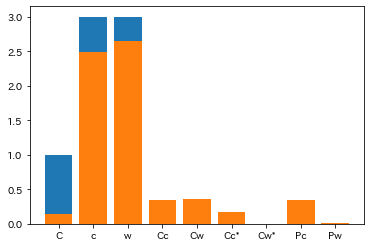

In [ ]:
test_seq = kiprf1(ki=test_ki,m=test_m,v=test_v,KW=test_KW,Kminus=test_Kminus,M=test_M,KL=test_KL,LC=test_LC,LW=test_LW,timescale=5.)
print(test_seq.error_rate()[-1])
test_seq.bar_transport()

0.0008528238456927248


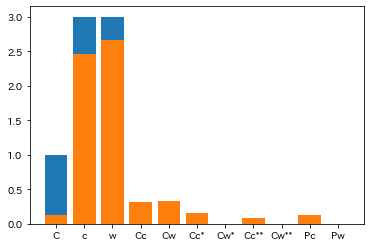

In [ ]:
test_seq2 = kiprf2(ki=test_ki,m=test_m,v=test_v,KW=test_KW,Kminus=test_Kminus,M=test_M,KL=test_KL,LC=test_LC,LW=test_LW,timescale=5.)
print(test_seq2.error_rate()[-1])
test_seq2.bar_transport()

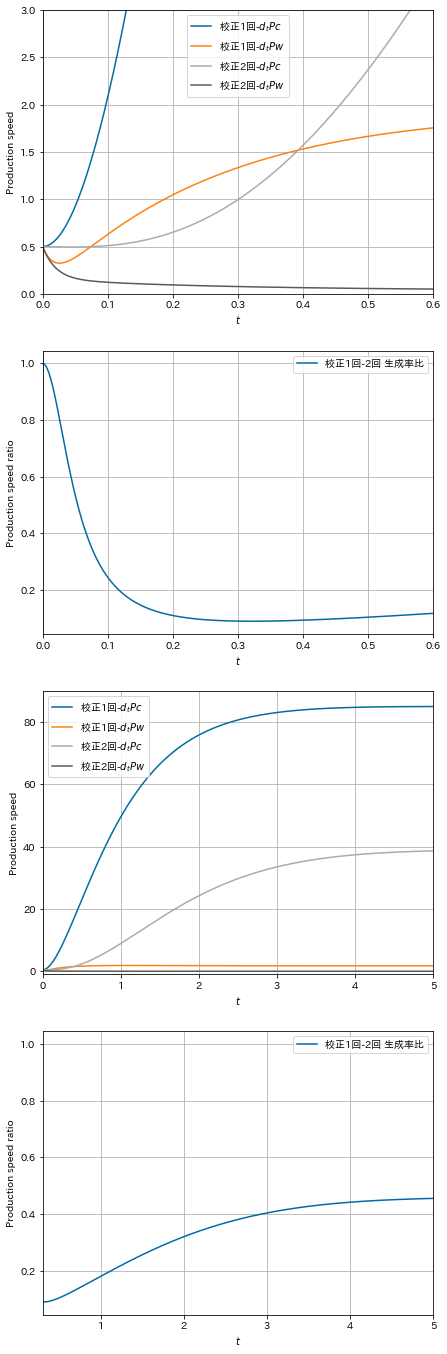

final production speed is 
 校正1回-$d_tPc$:84.96834701518068,
 校正1回-$d_tPw$:1.773486687019812,
 校正2回-$d_tPc$:38.65736120178891,
 校正2回-$d_tPw$:0.032996059270602215


In [ ]:
# 生産スピード比較
y = test_seq
y2 = test_seq2
fig = plt.figure(figsize=(7,24))
plt.style.use('tableau-colorblind10')
ax1 = fig.add_subplot(411)
ax1.plot(y.time, y.diff()[:,-4]*y.v/y.timebin, label="校正1回-$d_tPc$")
ax1.plot(y.time, y.diff()[:,-3]*y.v/y.timebin, label="校正1回-$d_tPw$")
ax1.plot(y2.time, y2.diff()[:,-4]*y2.v/y2.timebin, label="校正2回-$d_tPc$")
ax1.plot(y2.time, y2.diff()[:,-3]*y2.v/y2.timebin, label="校正2回-$d_tPw$")
ax1.set_xlim(0.0, 0.6)
ax1.set_ylim(0, 3)
ax1.grid()
ax1.set_xlabel("$t$")
ax1.set_ylabel("Production speed")
plt.legend()

ax4 = fig.add_subplot(412)
ax4.plot(y.time, (y2.diff()[:,-4]*y2.v/y2.timebin)/(y.diff()[:,-4]*y.v/y.timebin), label="校正1回-2回 生成率比")
ax4.set_xlim(0.0, 0.6)
ax4.grid()
ax4.set_xlabel("$t$")
ax4.set_ylabel("Production speed ratio")
plt.legend()

ax2 = fig.add_subplot(413)
ax2.plot(y.time, y.diff()[:,-4]*y.v/y.timebin, label="校正1回-$d_tPc$")
ax2.plot(y.time, y.diff()[:,-3]*y.v/y.timebin, label="校正1回-$d_tPw$")
ax2.plot(y2.time, y2.diff()[:,-4]*y2.v/y2.timebin, label="校正2回-$d_tPc$")
ax2.plot(y2.time, y2.diff()[:,-3]*y2.v/y2.timebin, label="校正2回-$d_tPw$")
ax2.set_xlim(0.0, 5.0)
ax2.set_ylim(-1, 90)
ax2.grid()
ax2.set_xlabel("$t$")
ax2.set_ylabel("Production speed")
plt.legend()

ax3 = fig.add_subplot(414)
ax3.plot(y.time, (y2.diff()[:,-4]*y2.v/y2.timebin)/(y.diff()[:,-4]*y.v/y.timebin), label="校正1回-2回 生成率比")
ax3.set_xlim(0.3, 5.0)
ax3.grid()
ax3.set_xlabel("$t$")
ax3.set_ylabel("Production speed ratio")
plt.legend()
plt.show()

print("final production speed is \n 校正1回-$d_tPc$:{},\n 校正1回-$d_tPw$:{},\n 校正2回-$d_tPc$:{},\n 校正2回-$d_tPw$:{}".format(y.diff()[-1,-4]*y.v/y.timebin, y.diff()[-1,-3]*y.v/y.timebin, y2.diff()[-1,-4]*y2.v/y2.timebin, y2.diff()[-1,-3]*y2.v/y2.timebin))
# 結論：生産率は1>2

In [ ]:
y.diff()

array([[1.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        1.00000000e-03, 1.00000000e-03, 1.00000000e-03],
       [9.97040114e-01, 2.99850314e+00, 2.99853697e+00, ...,
        9.66199361e-04, 1.00050009e-03, 1.00049161e-03],
       [9.94088978e-01, 2.99701147e+00, 2.99707751e+00, ...,
        9.34742225e-04, 1.00100038e-03, 1.00096690e-03],
       ...,
       [1.35827080e-01, 2.49203551e+00, 2.64379157e+00, ...,
        3.54696465e-03, 3.38415238e-01, 9.64907046e-03],
       [1.35827324e-01, 2.49203620e+00, 2.64379112e+00, ...,
        3.54696901e-03, 3.38500224e-01, 9.65084429e-03],
       [1.35827567e-01, 2.49203690e+00, 2.64379067e+00, ...,
        3.54697337e-03, 3.38585209e-01, 9.65261813e-03]])

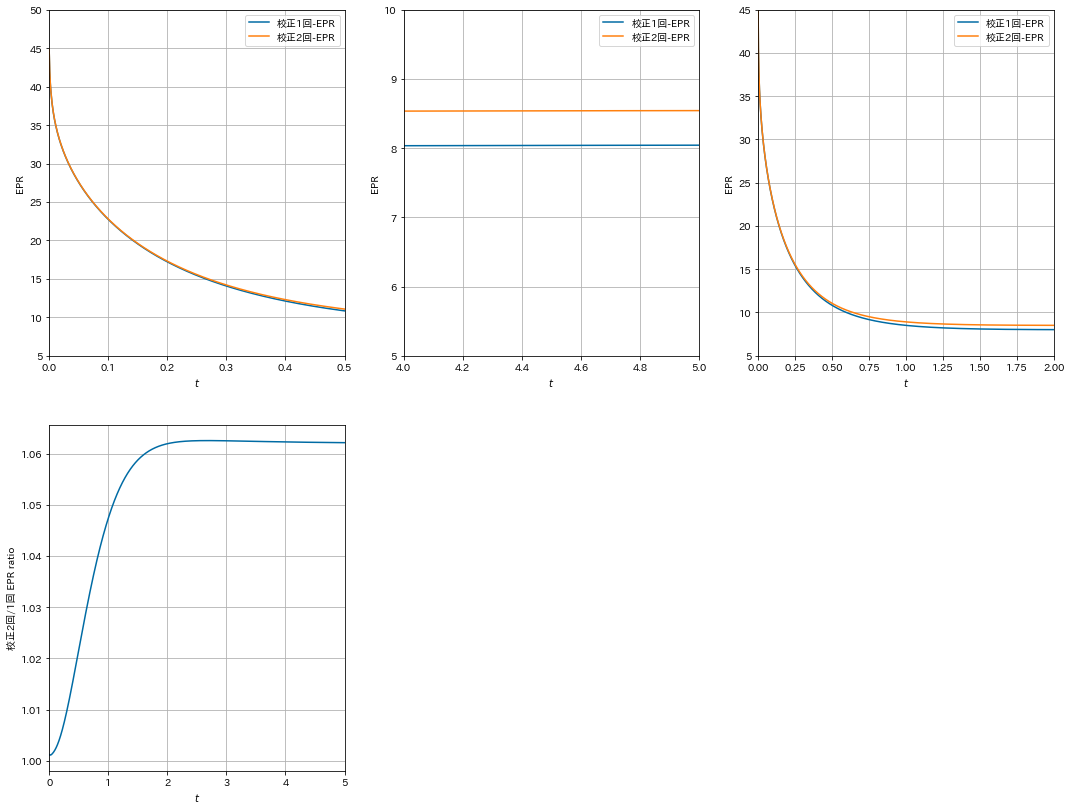

initial 
 校正1回-EPR:8.042567336436745,
 校正2回-EPR:8.54229436766975


In [ ]:
# EPR比較
#比をみる
y = test_seq
y2 = test_seq2
fig = plt.figure(figsize=(18,14))
plt.style.use('tableau-colorblind10')
ax1 = fig.add_subplot(231)
ax1.plot(y.time, y.calc_EPR(), label="校正1回-EPR")
ax1.plot(y2.time, y2.calc_EPR(), label="校正2回-EPR")
ax1.set_xlim(0.0, 0.5)
ax1.set_ylim(5, 50)
ax1.grid()
ax1.set_xlabel("$t$")
ax1.set_ylabel("EPR")
plt.legend()
ax2 = fig.add_subplot(232)
ax2.plot(y.time, y.calc_EPR(), label="校正1回-EPR")
ax2.plot(y2.time, y2.calc_EPR(), label="校正2回-EPR")
ax2.set_xlim(4.0, 5.0)
ax2.set_ylim(5, 10)
ax2.grid()
ax2.set_xlabel("$t$")
ax2.set_ylabel("EPR")
plt.legend()
ax3 = fig.add_subplot(233)
ax3.plot(y.time, y.calc_EPR(), label="校正1回-EPR")
ax3.plot(y2.time, y2.calc_EPR(), label="校正2回-EPR")
ax3.set_xlim(0.0, 2.0)
ax3.set_ylim(5, 45)
ax3.grid()
ax3.set_xlabel("$t$")
ax3.set_ylabel("EPR")
plt.legend()
ax4 = fig.add_subplot(234)
ax4.plot(y.time, y2.calc_EPR()/y.calc_EPR())
ax4.set_xlim(0.0, 5.0)
ax4.grid()
ax4.set_xlabel("$t$")
ax4.set_ylabel("校正2回/1回 EPR ratio")

plt.show()

print("initial \n 校正1回-EPR:{},\n 校正2回-EPR:{}".format(y.calc_EPR()[-1], y2.calc_EPR()[-1]))

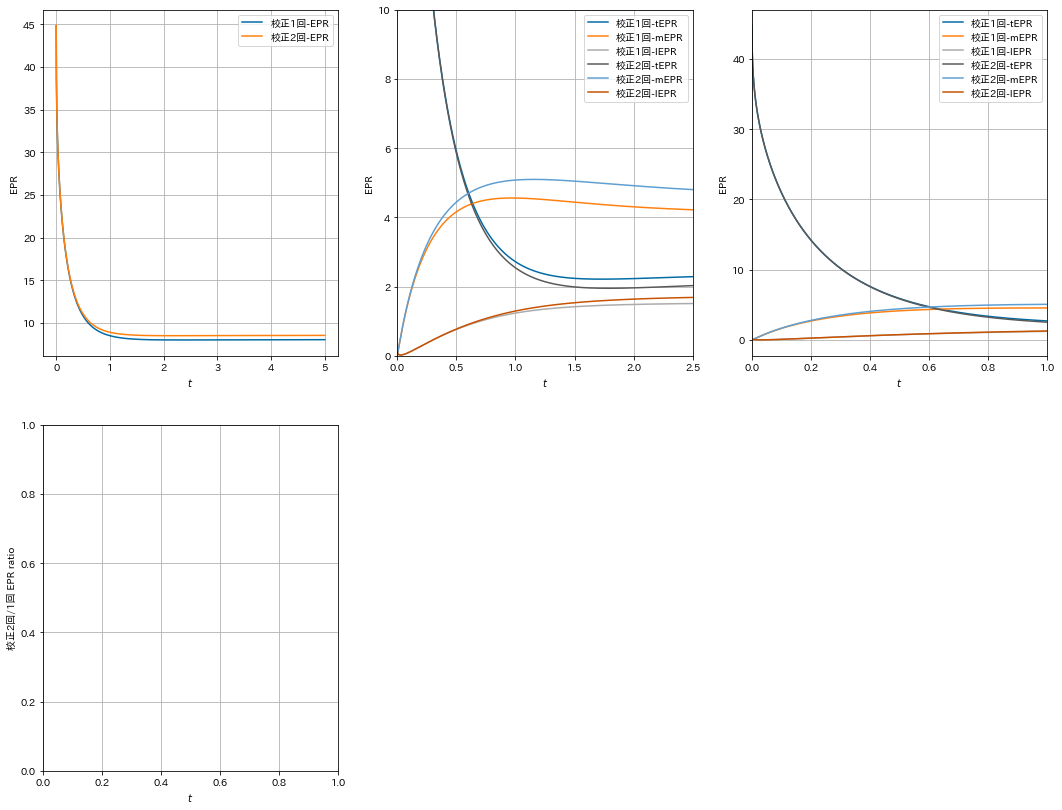

In [ ]:
# pEPR比較
#比をみる
y = test_seq
y2 = test_seq2
fig = plt.figure(figsize=(18,14))
plt.style.use('tableau-colorblind10')
ax1 = fig.add_subplot(231)
ax1.plot(y.time, y.calc_EPR(), label="校正1回-EPR")
ax1.plot(y2.time, y2.calc_EPR(), label="校正2回-EPR")
#ax1.set_xlim(0.0, 0.5)
#ax1.set_ylim(5, 50)
ax1.grid()
ax1.set_xlabel("$t$")
ax1.set_ylabel("EPR")
plt.legend()
ax2 = fig.add_subplot(232)
ax2.plot(y.time, y.calc_EPR()-y.mEPR()-y.lEPR(), label="校正1回-tEPR")
ax2.plot(y.time, y.mEPR(), label="校正1回-mEPR")
ax2.plot(y.time, y.lEPR(), label="校正1回-lEPR")
ax2.plot(y2.time, y2.calc_EPR()-y2.mEPR()-y2.lEPR(), label="校正2回-tEPR")
ax2.plot(y2.time, y2.mEPR(), label="校正2回-mEPR")
ax2.plot(y2.time, y2.lEPR(), label="校正2回-lEPR")
ax2.set_xlim(.0, 2.5)
ax2.set_ylim(0.,10.)
ax2.grid()
ax2.set_xlabel("$t$")
ax2.set_ylabel("EPR")
plt.legend()
ax3 = fig.add_subplot(233)
ax3.plot(y.time, y.calc_EPR()-y.mEPR()-y.lEPR(), label="校正1回-tEPR")
ax3.plot(y.time, y.mEPR(), label="校正1回-mEPR")
ax3.plot(y.time, y.lEPR(), label="校正1回-lEPR")
ax3.plot(y2.time, y2.calc_EPR()-y2.mEPR()-y2.lEPR(), label="校正2回-tEPR")
ax3.plot(y2.time, y2.mEPR(), label="校正2回-mEPR")
ax3.plot(y2.time, y2.lEPR(), label="校正2回-lEPR")
ax3.set_xlim(.0, 1.0)
ax3.grid()
ax3.set_xlabel("$t$")
ax3.set_ylabel("EPR")
plt.legend()
ax4 = fig.add_subplot(234)
#ax4.plot(y.time, y2.pEPR()/y.pEPR())
#ax4.set_xlim(0.0, 5.0)
ax4.grid()
ax4.set_xlabel("$t$")
ax4.set_ylabel("校正2回/1回 EPR ratio")

plt.show()

#print("initial \n 校正1回-EPR:{},\n 校正2回-EPR:{}".format(y.pEPR()[0], y2.pEPR()[0]))

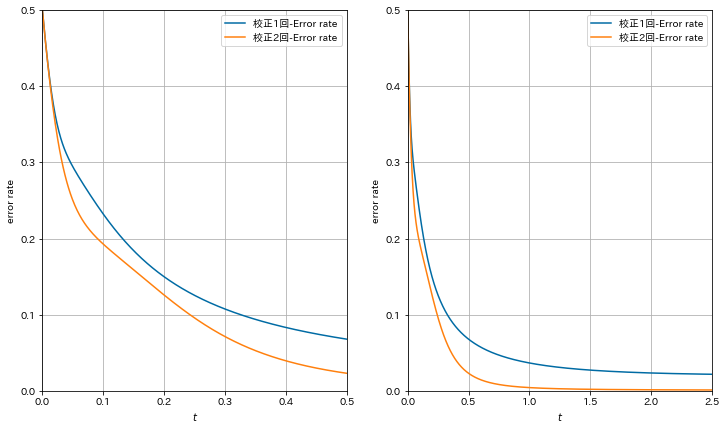

kiprf1's initial error rate is 0.5
kiprf2's initial error rate is 0.5


In [ ]:
# 生産スピード比較
y = test_seq
y2 = test_seq2
fig = plt.figure(figsize=(12,7))
plt.style.use('tableau-colorblind10')
ax = fig.add_subplot(121)
ax.plot(y.time, y.error_rate(), label="校正1回-Error rate")
ax.plot(y2.time, y2.error_rate(), label="校正2回-Error rate")
ax.set_xlim(0.0, .5)
ax.set_ylim(0.0, 0.5)
ax.grid()
ax.set_xlabel("$t$")
ax.set_ylabel("error rate")
plt.legend()
ax2 = fig.add_subplot(122)
ax2.plot(y.time, y.error_rate(), label="校正1回-Error rate")
ax2.plot(y2.time, y2.error_rate(), label="校正2回-Error rate")
ax2.set_xlim(0.0, 2.5)
ax2.set_ylim(0.0, 0.5)
ax2.grid()
ax2.set_xlabel("$t$")
ax2.set_ylabel("error rate")
plt.legend()
plt.show()

# 結論：エラー率は1>2
print("kiprf1's initial error rate is {}".format(y.error_rate()[0]))
print("kiprf2's initial error rate is {}".format(y2.error_rate()[0]))

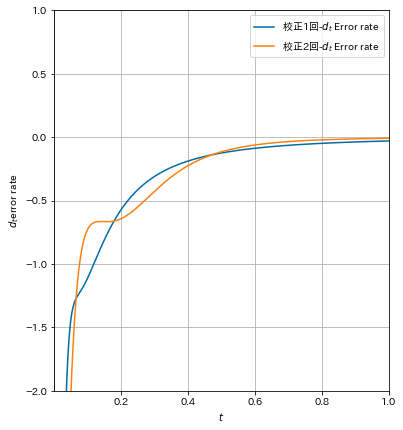

In [ ]:
# 生産スピード比較
fig = plt.figure(figsize=(6,7))
plt.style.use('tableau-colorblind10')
ax = fig.add_subplot(111)
y = test_seq
y2 = test_seq2
ax.plot(y.time, y.dt_error_rate(), label="校正1回-$d_t$ Error rate")
ax.plot(y2.time, y2.dt_error_rate(), label="校正2回-$d_t$ Error rate")
ax.set_xlim(0.001, 1.)
ax.set_ylim(-2.0, 1.0)
ax.grid()
ax.set_xlabel("$t$")
ax.set_ylabel("$d_t$error rate")
plt.legend()
plt.show()

